#### Libraries

In [1]:
import sys
sys.path.append("../common")

from clean_data import (
    contains_emoji,
    filter_non_standard_words,
    get_stop_words,
    generate_grams,
    remove_emoji
)
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
stop_words = get_stop_words()
jigsaw_df = pd.read_csv("../data/raw/train.csv")
jigsaw_df_test = pd.read_csv("../data/raw/test.csv")
jigsaw_df_test_labels = pd.read_csv("../data/raw/test_labels.csv")
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

jigsaw_df.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
jigsaw_df['comment_text'].where(jigsaw_df['comment_text'].apply(contains_emoji)).count()

np.int64(1198)

In [4]:
jigsaw_cleaned_df = jigsaw_df.copy()
jigsaw_cleaned_df['comment_text'] = jigsaw_cleaned_df['comment_text'].apply(remove_emoji)
jigsaw_cleaned_df['comment_text'].where(jigsaw_cleaned_df['comment_text'].apply(contains_emoji)).count()

np.int64(0)

In [5]:
# Replace special characters with an empty string
jigsaw_cleaned_df['comment_text'] = jigsaw_cleaned_df['comment_text'].str.replace(r'[^a-zA-Z0-9 ]', '', regex=True)

# Convert multilabel dataset to binary label and drop the multilabel columns
jigsaw_cleaned_df['is_toxic'] = jigsaw_cleaned_df[labels].any(axis=1).astype(int)
jigsaw_cleaned_df.drop(columns=labels, inplace=True)
jigsaw_cleaned_df.head(5)

,id,comment_text,is_toxic
0,0000997932d777bf,ExplanationWhy the edits made under my usernam...,0
1,000103f0d9cfb60f,Daww He matches this background colour Im seem...,0
2,000113f07ec002fd,Hey man Im really not trying to edit war Its j...,0
3,0001b41b1c6bb37e,MoreI cant make any real suggestions on improv...,0
4,0001d958c54c6e35,You sir are my hero Any chance you remember wh...,0


In [6]:
jigsaw_cleaned_df['comment_text'].isna().sum()

np.int64(0)

In [7]:
jigsaw_cleaned_df.shape

(159571, 3)

### Visualizations

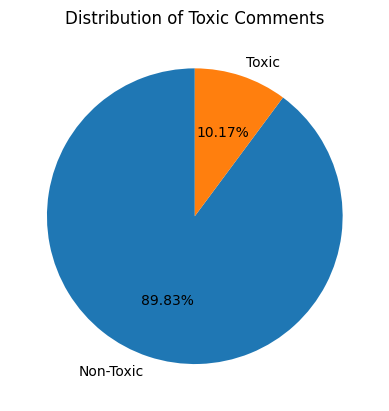

In [8]:
plt.pie(jigsaw_cleaned_df['is_toxic'].value_counts(), labels=['Non-Toxic', 'Toxic'], autopct='%1.2f%%', startangle=90)
plt.title('Distribution of Toxic Comments')
plt.show()

In [9]:
toxic_df = jigsaw_cleaned_df[jigsaw_cleaned_df['is_toxic'] == 1]['comment_text']
non_toxic_df = jigsaw_cleaned_df[jigsaw_cleaned_df['is_toxic'] == 0]['comment_text']

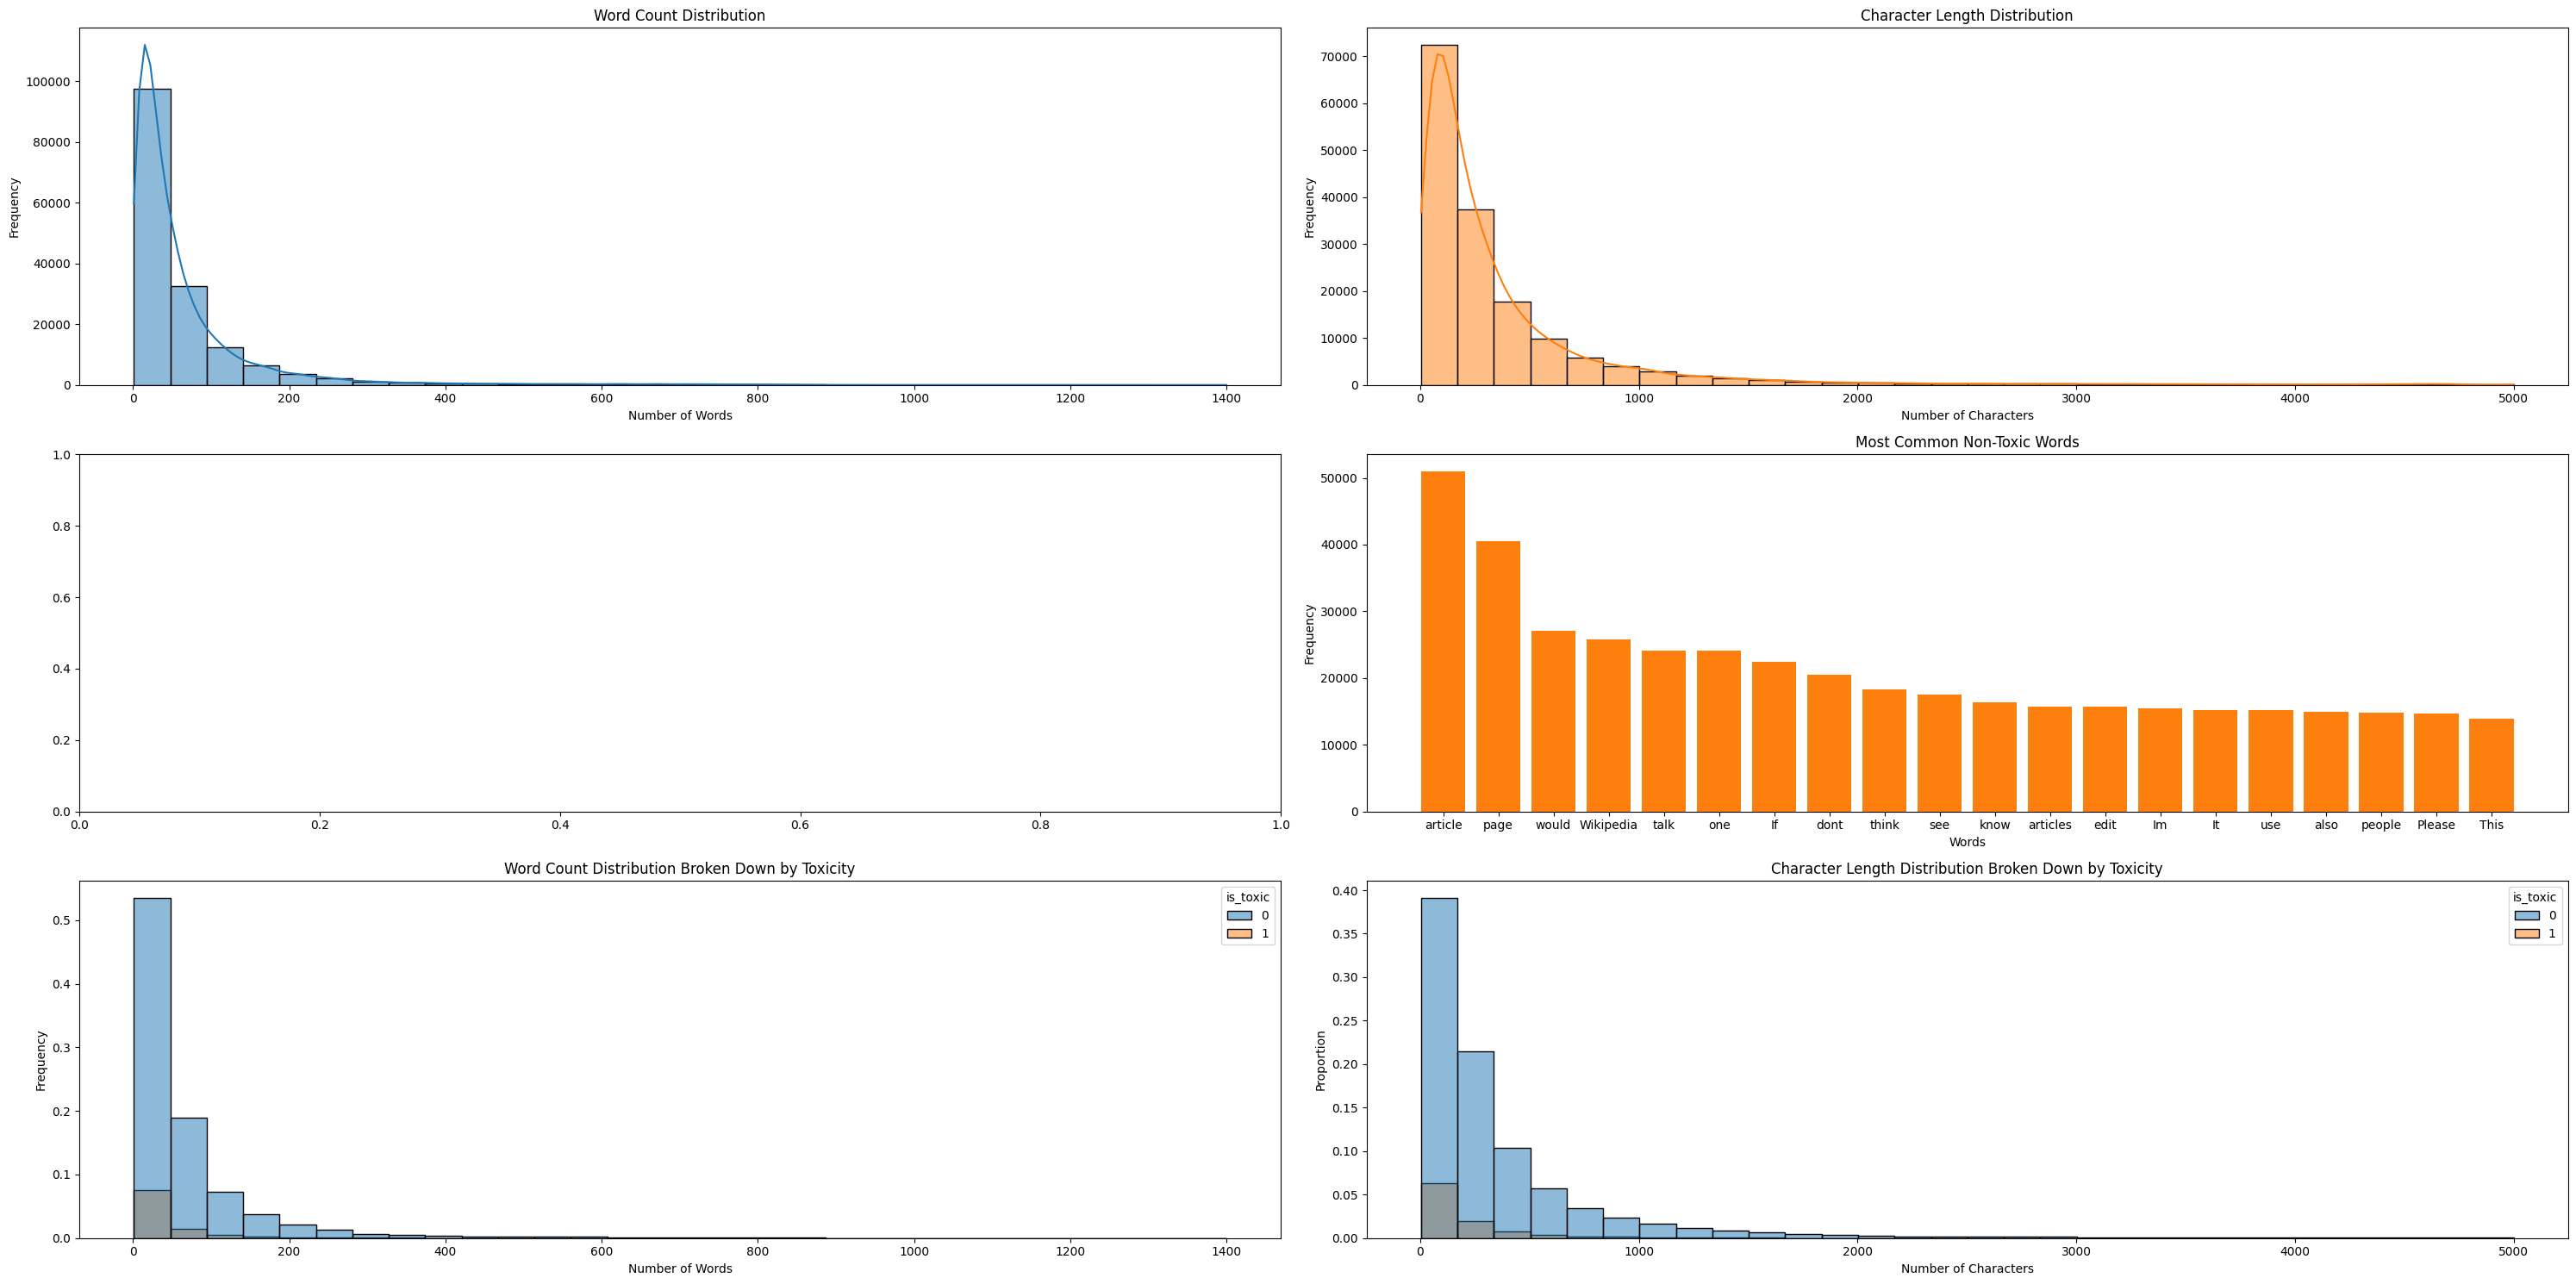

In [21]:
fig, axes = plt.subplots(3, 2, figsize=(30, 15))

# ============= Word count distribution ============


# Split each and get length of each string in the comment_text column
sns.histplot(jigsaw_cleaned_df['comment_text'].str.split().str.len(), bins=30, kde=True, color='tab:blue', ax=axes[0,0])
axes[0,0].set_title('Word Count Distribution')
axes[0,0].set_xlabel('Number of Words')
axes[0,0].set_ylabel('Frequency')


# ============= Word count distribution ============


# ========== Character length distribution ==========


# Get length of each string in the comment_text column
sns.histplot(jigsaw_cleaned_df['comment_text'].str.len(), bins=30, kde=True, color='tab:orange', ax=axes[0,1])
axes[0,1].set_title('Character Length Distribution')
axes[0,1].set_xlabel('Number of Characters')
axes[0,1].set_ylabel('Frequency')


# ========== Character length distribution ==========


# ================= Toxic Words ====================


# Get toxic/non-toxic words, split and create dataframe out of split, flatten into series, and count
toxic_words = toxic_df \
    .str.split(expand=True) \
    .stack() \
    .value_counts()

non_toxic_words = non_toxic_df \
    .str.split(expand=True) \
    .stack() \
    .value_counts()


# Filter out stop words
toxic_words = toxic_words[~toxic_words.index.isin(stop_words)]
non_toxic_words = non_toxic_words[~non_toxic_words.index.isin(stop_words)]
top_n_words = 20


# Plot top n Toxic Words
# axes[1,0].bar(toxic_words.head(top_n_words).index, toxic_words.head(top_n_words).values, color='tab:blue')
# axes[1,0].set_title('Most Common Toxic Words')
# axes[1,0].set_xlabel('Words')
# axes[1,0].set_ylabel('Frequency')


# Plot top n Non-Toxic Words
axes[1,1].bar(non_toxic_words.head(top_n_words).index, non_toxic_words.head(top_n_words).values, color='tab:orange')
axes[1,1].set_title('Most Common Non-Toxic Words')
axes[1,1].set_xlabel('Words')
axes[1,1].set_ylabel('Frequency')


# ================= Toxic Words ====================


# ================= Word and Character Distribution by Toxicity ====================


sns.histplot(
             data=jigsaw_cleaned_df,
             x=jigsaw_cleaned_df['comment_text'].str.split().str.len(), 
             bins=30, 
             hue=jigsaw_cleaned_df['is_toxic'],
             stat="proportion",
             palette=['tab:blue', 'tab:orange'], 
             ax=axes[2,0]
)
axes[2,0].set_title('Word Count Distribution Broken Down by Toxicity')
axes[2,0].set_xlabel('Number of Words')
axes[2,0].set_ylabel('Frequency')


sns.histplot(
             data=jigsaw_cleaned_df,
             x=jigsaw_cleaned_df['comment_text'].str.len(),
             bins=30, 
             hue=jigsaw_cleaned_df['is_toxic'],
             stat="proportion",
             palette=['tab:blue', 'tab:orange'], 
             ax=axes[2,1]
)
axes[2,1].set_title('Character Length Distribution Broken Down by Toxicity')
axes[2,1].set_xlabel('Number of Characters')
axes[2,1].set_ylabel('Proportion')


# ================= Word and Character Distribution by Toxicity ====================


plt.tight_layout()
plt.show()

In [11]:
jigsaw_cleaned_df['word_count'] = jigsaw_cleaned_df['comment_text'].str.split().str.len()

In [12]:
jigsaw_cleaned_df.columns

Index(['id', 'comment_text', 'is_toxic', 'word_count'], dtype='object')

In [13]:
jigsaw_cleaned_df.groupby('is_toxic')['word_count'].describe()

,count,mean,std,min,25%,50%,75%,max
is_toxic,,,,,,,,
0,143346.0,67.076242,96.140193,1.0,17.0,36.0,76.0,1250.0
1,16225.0,51.340709,104.304201,1.0,11.0,22.0,49.0,1400.0


### N-gram analysis

In [14]:
# More useful to detect duplicate/near-duplicates, patterns, etc.

# for n in range(2, 5):
    # Generate Series of lists n-grams
    # n_grams = jigsaw_cleaned_df['comment_text'].apply(lambda x: generate_grams(x, n))
    # Convert Series of lists to DataFrame (each column is a n-gram)
    # n_gram_df = pd.DataFrame(n_grams.tolist())

    # Create a Series of string n-grams and count
    # n_gram_counts = n_gram_df.apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1).value_counts()
    # n_gram_counts = n_gram_counts.drop(index=0)
    # print(n_gram_counts.head(10))

In [15]:
# from collections import Counter
# test_n_grams = jigsaw_cleaned_df['comment_text'].apply(lambda x: generate_grams(x, n=2))
# flat_n_grams = [n_gram for n_grams_lst in test_n_grams for n_gram in n_grams_lst]
# dictionary of n-grams and their counts
# n_gram_counts = Counter(flat_n_grams)
# n_grams_df = pd.DataFrame(n_gram_counts.items(), columns=['n_gram', 'count']).sort_values(by='count', ascending=False)
# n_grams_df.info()

In [16]:
toxic_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(toxic_df))
non_toxic_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(non_toxic_df))

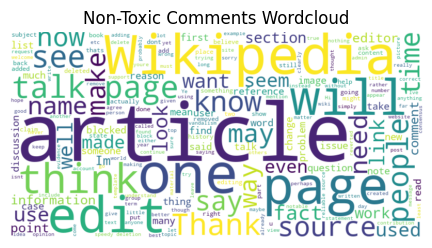

In [17]:
# Plot the wordclouds
# plt.figure(figsize=(20, 10))
# plt.subplot(2, 1, 1)
# plt.imshow(toxic_wordcloud, interpolation='bilinear')
# plt.title('Toxic Comments Wordcloud')
# plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(non_toxic_wordcloud, interpolation='bilinear')
plt.title('Non-Toxic Comments Wordcloud')
plt.axis('off')

plt.tight_layout()
plt.show()

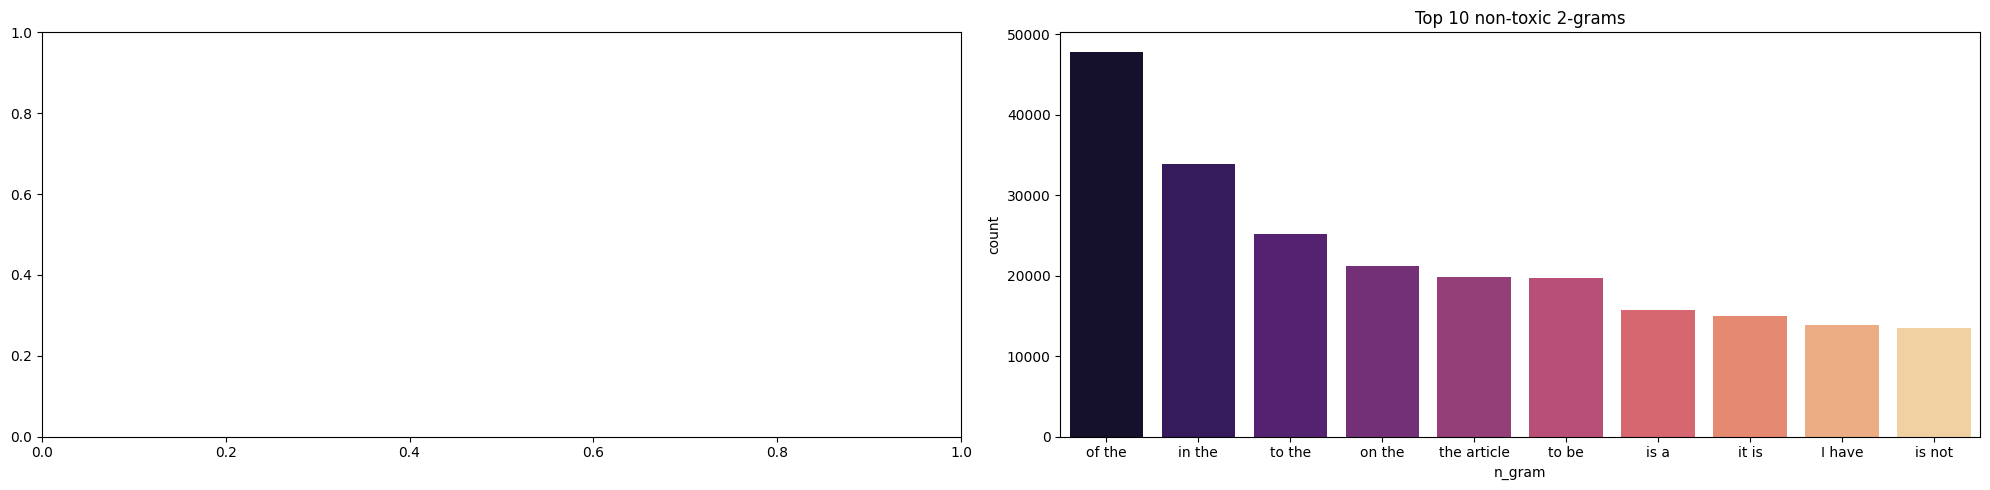

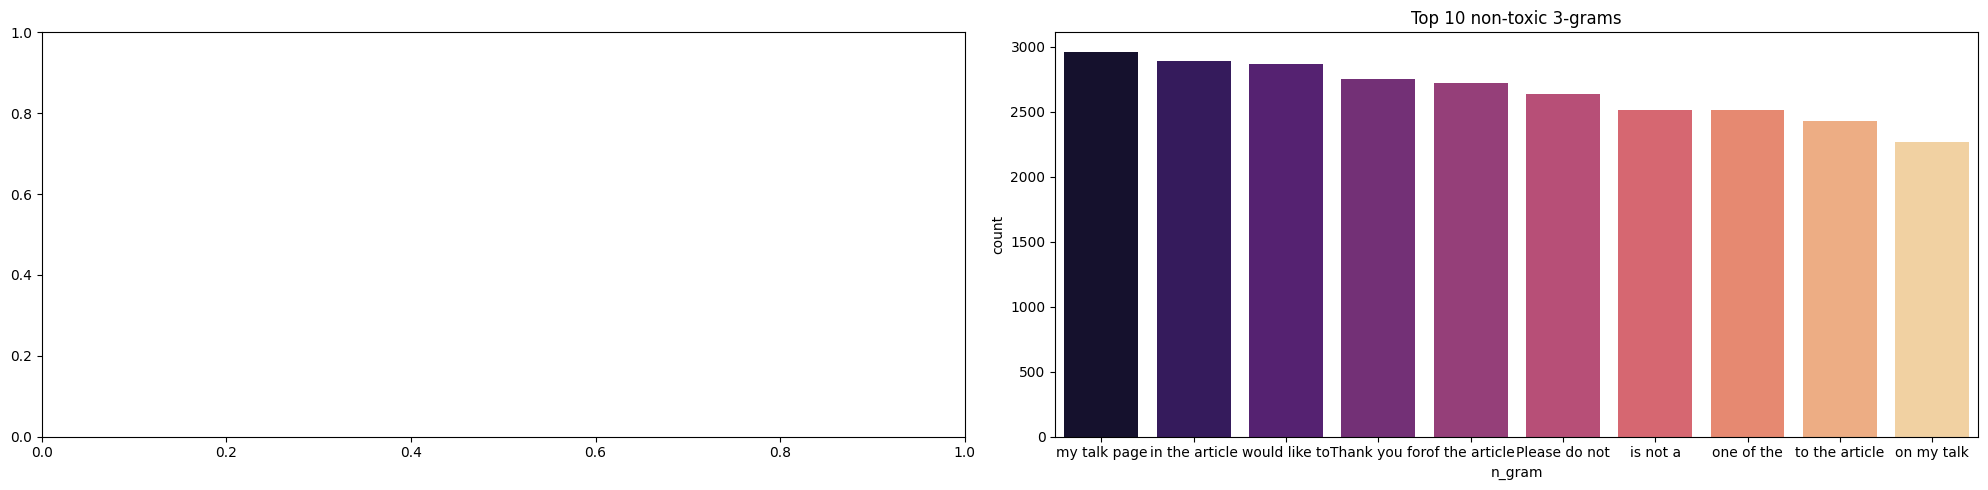

In [23]:
from collections import Counter
for n in range(2, 4):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

    # ===== Generate Series of lists n-grams =====

    toxic_ngrams_series = toxic_df.apply(lambda x: generate_grams(x, n)).reset_index(drop=True)
    non_toxic_ngrams_series = non_toxic_df.apply(lambda x: generate_grams(x, n)).reset_index(drop=True)

    # ===== Generate Series of lists n-grams =====

    
    # ===== Flatten n-grams into one list and Count occurences of each n-gram ===== 
    
    flat_toxic_ngrams = [n_gram for n_grams_lst in toxic_ngrams_series for n_gram in n_grams_lst]
    flat_non_toxic_ngrams = [n_gram for n_grams_lst in non_toxic_ngrams_series for n_gram in n_grams_lst]

    toxic_n_gram_counts = Counter(flat_toxic_ngrams)
    non_toxic_n_gram_counts = Counter(flat_non_toxic_ngrams)

    # ===== Flatten n-grams into one list and Count occurences of each n-gram ===== 


    # ===== Create dataframes from n_gram_counts =====
    
    toxic_n_gram_counts_df = pd.DataFrame(toxic_n_gram_counts.items(), columns=['n_gram', 'count']) \
                         .sort_values(by='count', ascending=False)
    toxic_n_gram_counts_df['n_gram'] = toxic_n_gram_counts_df['n_gram'].apply(lambda x: ' '.join(x))


    non_toxic_n_gram_counts_df = pd.DataFrame(non_toxic_n_gram_counts.items(), columns=['n_gram', 'count']) \
                         .sort_values(by='count', ascending=False)
    non_toxic_n_gram_counts_df['n_gram'] = non_toxic_n_gram_counts_df['n_gram'].apply(lambda x: ' '.join(x))

    # ===== Create dataframes from n_gram_counts =====


    # sns.barplot(data=toxic_n_gram_counts_df.head(10), x='n_gram', y='count', ax=axes[0], palette='magma').set_title(f'Top 10 toxic {n}-grams')
    sns.barplot(data=non_toxic_n_gram_counts_df.head(10), x='n_gram', y='count', ax=axes[1], palette='magma').set_title(f'Top 10 non-toxic {n}-grams')
    
    plt.tight_layout()
    plt.show()
    

In [19]:
jigsaw_df_test.head(5)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [20]:
# Get rows that have negative labels (Series of booleans)
has_negative_labels = (jigsaw_df_test_labels[labels] == -1).any(axis=1)

# Copy test_labels df and remove rows with negative labels
jigsaw_df_test_labels_clean = jigsaw_df_test_labels.copy()
jigsaw_df_test_labels_clean = jigsaw_df_test_labels_clean[~has_negative_labels]
jigsaw_df_test_labels_clean.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,0,0,0,0,0,0
7,000247e83dcc1211,0,0,0,0,0,0
11,0002f87b16116a7f,0,0,0,0,0,0
13,0003e1cccfd5a40a,0,0,0,0,0,0
14,00059ace3e3e9a53,0,0,0,0,0,0
16,000663aff0fffc80,0,0,0,0,0,0
17,000689dd34e20979,0,0,0,0,0,0
19,000844b52dee5f3f,0,0,0,0,0,0
21,00091c35fa9d0465,1,0,0,0,0,0
22,000968ce11f5ee34,0,0,0,0,0,0


### Results from EDA

* The jigsaw dataset was downloaded from Kaggle, from their Toxic Comment Classification Challenge.
* There are a lot of toxic comments within this dataset, about 10.17% or 16,000 comments.
* From the histogram plots breaking down the data by toxicity (the bottom two plots), we see that a higher proportion of toxic comments  
  fall into longer word and character length bins compared to non-toxic ones. Meaning longer comments are more likely to be toxic relative  
  to other toxic comments. Based off the average word count by toxicity, toxic comments tend to be shorter than non-toxic ones with a mean  
  of 51.3 words compared to 67.1 words. So, we're able to create a word_count feature that could potentially help us classify toxic comments.  
  Many toxic comments are more likely to be short, but longer comments have a higher chance of being toxic. This could be due to  
  * Short insults or slurs, which we see in our word clouds or
  * rants, arguments, and personal attacks in longer messages